In [1]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install catboost
from catboost import CatBoostClassifier
import os
# Monter le Drive
from google.colab import drive
drive.mount('/content/drive')
# Changer de répertoire vers SteamAnalyse
project_dir = '/content/drive/MyDrive/SteamAnalyse'
os.chdir(project_dir)

path="train.parquet"
path_test="test.parquet"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
df = pd.read_parquet(path)
dft = pd.read_parquet(path_test)

In [3]:
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

In [4]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols + cols_text
target = "succes"

X_train = df[features].copy()
for c in cols_text: X_train[c] = X_train[c].apply(clean_text_col)
y_train = np.log1p(df[target])

In [5]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols + cols_text
target = "succes"

X_test = dft[features].copy()
for c in cols_text: X_test[c] = X_test[c].apply(clean_text_col)
y_test = dft[target]

In [6]:
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [7]:
cat = CatBoostClassifier(
    depth=10,
    text_features=cols_text,
    verbose=100,
    auto_class_weights='Balanced',
    task_type="GPU",
     eval_metric='AUC' )

cat.fit(X_train, y_train)

Learning rate set to 0.027235


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 595ms	remaining: 9m 54s
100:	total: 45.2s	remaining: 6m 42s
200:	total: 1m 25s	remaining: 5m 41s
300:	total: 2m 10s	remaining: 5m 2s
400:	total: 2m 55s	remaining: 4m 21s
500:	total: 3m 40s	remaining: 3m 39s
600:	total: 4m 25s	remaining: 2m 55s
700:	total: 5m 9s	remaining: 2m 12s
800:	total: 5m 54s	remaining: 1m 28s
900:	total: 6m 39s	remaining: 43.9s
999:	total: 7m 23s	remaining: 0us


Champion AUC : 0.9465
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      5235
           1       0.24      0.74      0.37       140

    accuracy                           0.93      5375
   macro avg       0.62      0.84      0.67      5375
weighted avg       0.97      0.93      0.95      5375



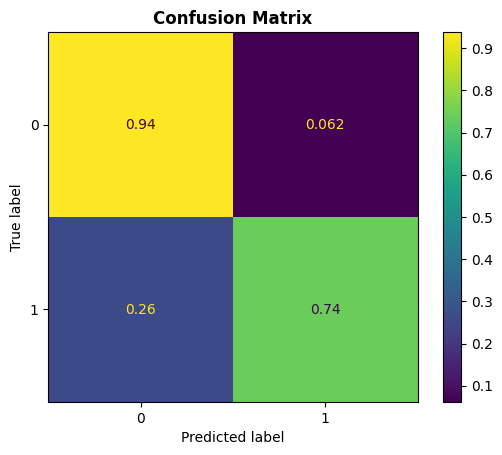

In [8]:
y_pred_transformed_labels = cat.predict(X_test)

# For classification report and confusion matrix, we need binary integer labels (0 or 1)
# Convert y_test (boolean) to integer (0 or 1)
y_test_binary_labels = y_test.astype(int)

# Convert y_pred_transformed_labels (values like 0.0 or ~0.693 from np.log1p) back to binary integer labels (0 or 1)
y_pred_binary_labels = np.round(np.expm1(y_pred_transformed_labels)).astype(int)

# For AUC, use predicted probabilities of the positive class from the model
y_pred_proba = cat.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test_binary_labels, y_pred_proba)

# --- RESULTAT ---
print(f"Champion AUC : {auc:.4f}")
print(classification_report(y_test_binary_labels, y_pred_binary_labels))
ConfusionMatrixDisplay.from_predictions(
    y_test_binary_labels,
    y_pred_binary_labels,
    normalize="true"
)

plt.title("Confusion Matrix", fontweight="bold")
plt.show()